In [1]:

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_community.llms import Ollama


In [39]:
ollm =Ollama(model="llama3")

In [64]:

prompt = PromptTemplate(
    template="""You are an math and science expert at routing a user question to a math or science. \n
    understand the content and find the question is relavant to maths or science. \n
    Give a binary choice 'math' or 'science' based on the question. \n
    Return the a JSON with a single key 'subject' and no premable or explanation. \n
    Question to route: {question}""",
    input_variables=["question"],
)

sub_router = prompt | ollm | JsonOutputParser()
question = "what is 2 + 4"
print(sub_router.invoke({"question": question}))

{'subject': 'math'}


In [18]:
math_prompt = PromptTemplate(
    template="""You are an excellent math professor that likes to solve math questions in a way that everyone can understand your solution
    Provide the solution to the students that are asking below mathematical questions and give them the answer. \n
    Return process to solve the given maths problem. \n
    Question: {question}""",
    input_variables=["question"],
)

math_chain = math_prompt | ollm | StrOutputParser()
question = "what is 2 + 10 + 22"
print(math_chain.invoke({"question": question}))

I'd be happy to help you with that!

When we're adding numbers together, one way to think about it is like having a bunch of boxes, and each number is a certain amount of money we have in our pocket. Let's see how this works:

We start with the first number: 2. That's like having 2 dollars in our pocket.

Next, we add 10. That's like getting another 10 dollars! So now we have a total of 2 + 10 = 12 dollars.

Finally, we add 22. That's like getting a big ol' handful of cash - 22 dollars! Now we're up to 12 + 22 = 34 dollars!

So, the answer is: 2 + 10 + 22 = 34

How was that? Did I make it easy to understand?


In [21]:
science_prompt = PromptTemplate(
    template="""You are an excellent science professor that likes to solve science questions in a way that everyone can understand your solution
    Provide the solution to the students that are asking below science questions and give them the answer. \n
    Return process to solve the given science problem. \n
    Question: {question}""",
    input_variables=["question"],
)

science_chain = science_prompt | ollm | StrOutputParser()
question = "how to reach boiling point"
print(science_chain.invoke({"question": question}))

I love solving science questions in a way that's easy for everyone to understand!

The question is, "How to reach boiling point?" Well, let me tell you, it's actually quite simple! Boiling point is the temperature at which a liquid turns into a gas. For example, water boils at 100°C or 212°F (at sea level).

To reach the boiling point of a substance, you need to heat it up until it reaches that temperature. Here are some steps to help you do just that:

1. **Choose your substance**: Which liquid do you want to boil? Water, perhaps? Or maybe something else?
2. **Get the right equipment**: You'll need a heat source (like a stove or microwave), a container to hold the liquid, and a thermometer to measure the temperature.
3. **Heat it up slowly**: Place your substance in the container and start heating it up gradually. Don't try to boil it too quickly!
4. **Monitor the temperature**: Use your thermometer to check the temperature of the liquid as you heat it up. You can also look for signs 

In [22]:
story_prompt = PromptTemplate(
    template=""" You are an creative fictional story writer and create interesting story for given mathemetical or science answer in a way that everyone can like it
    Create the small story for the kids with the below mathematical or science answer\n
    Answer: {answer}""",
    input_variables=["answer"],
)

story_chain = story_prompt | ollm | StrOutputParser()
question = "how to reach boiling point"
print(story_chain.invoke({"answer": question}))

What a great question! Here's a story I came up with:

**The Adventures of Luna and Leo**

In the mystical land of Temperatureia, two curious friends, Luna and Leo, lived in a tiny village called Celsiusville. They loved solving puzzles and exploring the world around them.

One sunny day, they stumbled upon a magical cauldron hidden deep in the forest. The villagers warned them to stay away from it, saying that only a brave adventurer could reach the boiling point of water inside the cauldron.

Intrigued, Luna and Leo decided to take on the challenge. They carefully observed the temperature of the cauldron, noting how it rose as they poured in more fuel (wood chips). With each added log, the temperature gauge marked 100°F (38°C), then 120°F (49°C), and eventually reached a thrilling 212°F (100°C) – the boiling point!

As they approached the magical threshold, Luna exclaimed, "Look! The water is starting to bubble!" Leo grinned, saying, "That's when we know we've reached the perfect tem

State

In [23]:
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        answer: LLM generation
        story: story
    """

    question: str
    answer: str
    story: str

Nodes

In [33]:
def math_agent(state):
    question = state["question"]
    print(question)
    answer = math_chain.invoke({"question": question})
    return {"answer": answer}


In [25]:
def science_agent(state):
    question = state["question"]
    answer = science_chain.invoke({"question": question})
    return {"answer": answer}


In [27]:
def story_agent(state):
    answer = state["answer"]
    story = story_chain.invoke({"answer": answer})
    return {"story": story}


Edges

In [40]:
def route_question(state):
    question = state["question"]
    source = sub_router.invoke({"question": question})
    if source["subject"] == "math":
        return "math"
    elif source["subject"] == "science":
        return "science"

Graph

In [41]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("math", math_agent) 
workflow.add_node("science", science_agent)  
workflow.add_node("write_story", story_agent)  

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "math": "math",
        "science": "science",
    },
)
workflow.add_edge("math", "write_story")
workflow.add_edge("science", "write_story")
workflow.add_edge("write_story", END)
# Compile
app = workflow.compile()

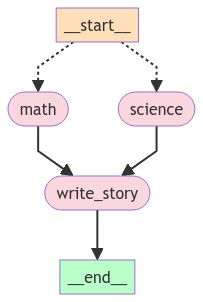

In [42]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [43]:
import pprint

inputs = {
    "question":  "what 2 + 3 + 4"
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

what 2 + 3 + 4
{'subject': 'math'}
what 2 + 3 + 4
"Output from node 'math':"
'---'
{ 'answer': 'I love helping students with their math questions!\n'
            '\n'
            "So, let's break down this simple yet fun question together: "
            '"What is 2 + 3 + 4?"\n'
            '\n'
            "To make it easy to understand, I'll use a visual approach. "
            'Imagine you have three boxes labeled A, B, and C.\n'
            '\n'
            'Box A has 2 items.\n'
            'Box B has 3 items.\n'
            'Box C has 4 items.\n'
            '\n'
            "Now, let's count the total number of items by combining what's in "
            'each box:\n'
            '\n'
            '1. Box A (2) + Box B (3) = 5\n'
            '2. Then, add Box C (4) to that sum: 5 + 4 = 9\n'
            '\n'
            'So, the answer is... **9**!\n'
            '\n'
            "To put it simply, when you add 2 + 3 + 4, you're counting the "
            "total number of items in t

In [46]:
inputs = {
    "question":  "what 2 + 3"
}
final_states = app.invoke(inputs)


what 2 + 3
{'subject': 'math'}
what 2 + 3


In [48]:
final_states["story"]

'Once upon a time, in a tiny village nestled between two great mountains, there lived a little rabbit named Rosie. Rosie loved to play with her friends and count all sorts of treasures they would find on their adventures.\n\nOne sunny day, Rosie\'s best friend, Benny the bear, gave her 2 shiny acorns as a gift. Rosie was overjoyed! She counted them carefully: one, two. "Ah," she thought, "I have two wonderful acorns now!"\n\nJust then, their friends, Sammy the squirrel and Lily the ladybug, came bounding up the mountain trail, chattering excitedly about a new discovery they had made. They presented Rosie with 3 more acorns! Rosie\'s eyes grew wide with wonder. She counted them: one, two, three.\n\nAs she looked at her growing pile of acorns, Rosie realized that Benny\'s original gift was still part of the total count. "Hmmm," she thought, "if I had 2 acorns and then got 3 more, how many do I have now?"\n\nWith a mischievous grin, Rosie began to count her treasure again: one, two... (dr